# Assigment 04: Due 10/1

You can use these imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
import scipy.special as sf
%matplotlib notebook

# Problem 1a

Using Monte Carlo techniques discusses in *02_Integration_MC* notebook, solve the following integral and compare it to the exact solution:

$\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}}dx$

In your Monte Carlo integration, use 10,000 random points.

In [2]:
f = lambda x: (2 / (((2 ** 2) + (x ** 2)) ** (3 / 2)))
N = 10_000
x_lo = 0
x_hi = 2
x = np.linspace(x_lo, x_hi, N)
y = f(x)
y_hi = max(y)
y_lo = 0
x_rand = x_lo + x_hi * np.random.random(N)
y_rand = y_lo + y_hi * np.random.random(N)
i_below, = np.where(y_rand < f(x_rand))
i_above, = np.where(y_rand >= f(x_rand))
ratio = len(i_below) / N
area = (x_hi - x_lo) * y_hi
integral = ratio * area
print(f'    fmax = {y_hi}\n   ratio = {ratio}\n    area = {area}\nintegral = {integral}')

    fmax = 0.25
   ratio = 0.7015
    area = 0.5
integral = 0.35075


$\begin{align*}
\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}} \;dx &= 2 \int_0^2 \frac{1}{(4 + x^2)^{3/2}} \;dx \\
\end{align*}$

$\begin{align*}
x &= 2 \tan{(u)} \implies dx = 2 \sec^2{(u)} \\
2 &= 2 \tan{(u)} \implies u = \tan^{-1}(1) = \frac{\pi}{4} \\
0 &= 2 \tan{(u)} \implies u = \tan^{-1}(0) = 0
\end{align*}$

$\begin{align*}
\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}} \;dx &= 2 \int_0^{\pi / 4} \frac{2 \sec^2{(u)}}{(4 + (2 \tan{(u)})^2)^{3/2}} \;du \\
&= 2 \int_0^{\pi / 4} \frac{2 \sec^2{(u)}}{4 (1 + \tan^2{(u)})^{3/2}} \;du \\
&= \frac{1}{2} \int_0^{\pi / 4} \frac{1}{\sec{(u)}} \;du \\
&= \frac{1}{2} \int_0^{\pi / 4} \cos{(u)} \;du \\
&= \frac{1}{2} \big[\sin{(u)}\big]_0^{\pi / 4} \\
&= \frac{1}{2} \left[\sin{\left(\frac{\pi}{4}\right)} - \sin{(0)}\right] \\
&= \frac{1}{2} \left[\frac{1}{\sqrt{2}} - 0\right] \\
&= \frac{1}{2 \sqrt{2}}
\end{align*}$

In [3]:
1 / (2 * np.sqrt(2))

0.35355339059327373

The computed solution and exact solution are close (approximately 0.35).

# 1b

Make a scatter plot of points below and above the integrand function. This is the some type of graph shown in the *02_Integration_MC* notebook with the blue and green points.

<IPython.core.display.Javascript object>


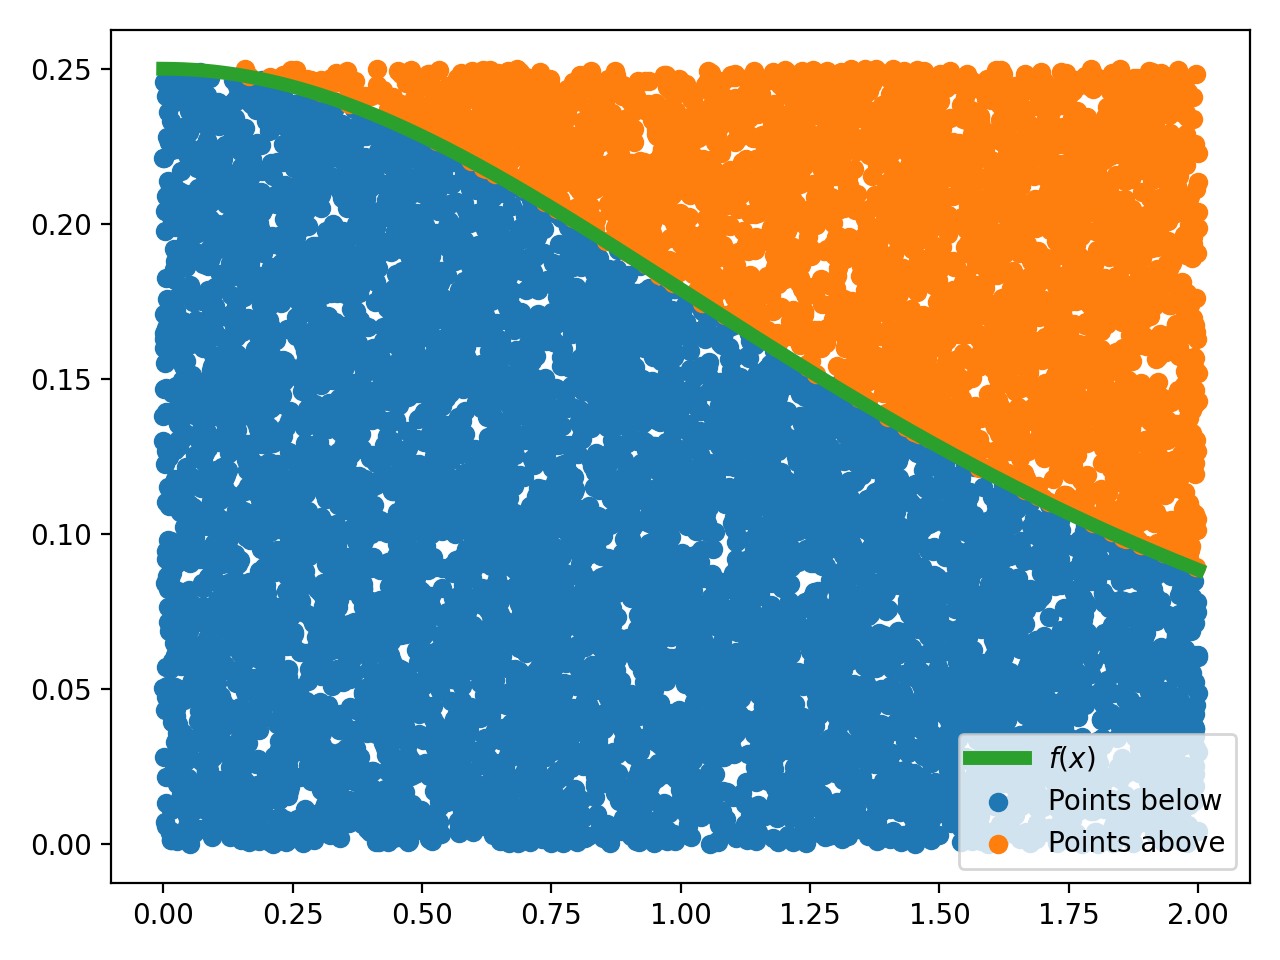

In [4]:
fig = plt.figure()
plt.scatter(x_rand[i_below], y_rand[i_below], label = 'Points below')
plt.scatter(x_rand[i_above], y_rand[i_above], label = 'Points above')
plt.plot(x, y, 'C2', lw=5, label = '$f(x)$')
plt.legend()
plt.tight_layout();

# Problem 2a
Read in the data set *./data/decay_data.txt*, this lists the time in days, number of particles, and the uncertianty on the particles. This is the same radio active decay data set used in our fitting example *Fitting_Lecture_Notes* from Module 2b.

Plot the data with its error bars.


<IPython.core.display.Javascript object>


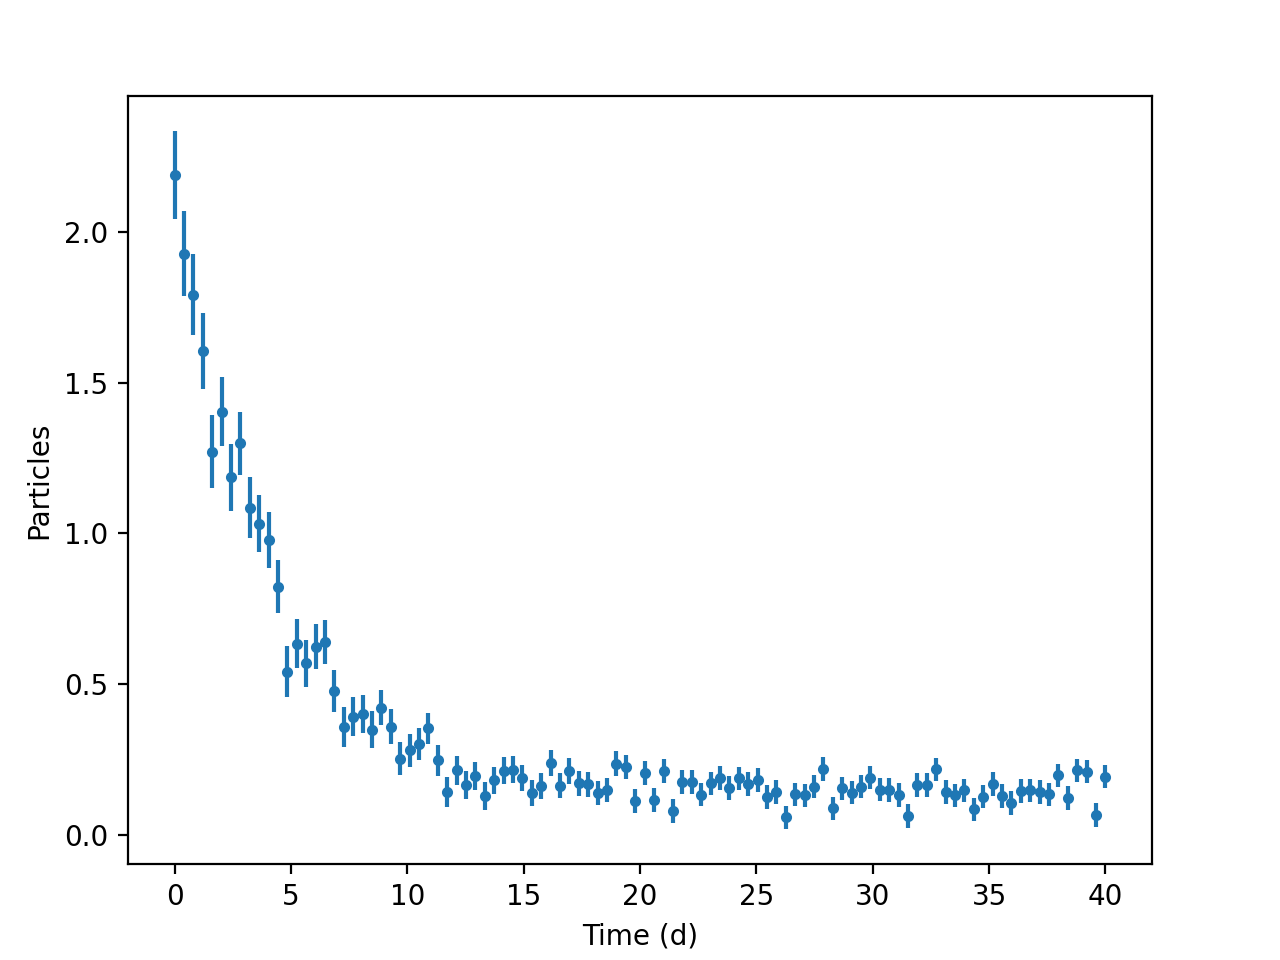

In [5]:
decay_t, decay_N, decay_N_error = np.loadtxt('data/decay_data.txt', unpack=True)
decay_fig = plt.figure()
decay_axs = decay_fig.add_axes([0.1,0.1,0.8,0.8])
decay_axs.errorbar(decay_t, decay_N, yerr = decay_N_error, fmt='.')
decay_axs.set_xlabel('Time (d)')
decay_axs.set_ylabel('Particles');

# Problem 2b

Fit the data with 3 fit parameters using MCMC MH algorithm. You should take 10,000 steps and impliment the random test on $\chi ^2$, like we did our *03_MC_Fit* example notebook using the *get_chi_squared* function. For this we will use a function template of: $y = p_0 \cdot e^{-t/p_1} + p_2$,

where $p_0, p_1$, and $p_2$ are the fit parameters. When fitting you should choose starting values of $p_0 = p_1 = p_2 = 1.0$ to avoid nan errors.

In [6]:
def decay_fit(t, p0, p1, p2):
    if p1 == 0:
        return p2
    return p0 * np.exp(-t / p1) + p2

In [7]:
def get_chi_squared(x, y, σ, p):
    return sum([((y[i] - decay_fit(x[i], *p)) / σ[i]) ** 2 for i in range(0, len(x))])

In [8]:
init_params = np.zeros(3)
params_list = [init_params]
RRs = [get_chi_squared(decay_t, decay_N, decay_N_error, init_params)]
for i in range(10000):
    test_params = [np.random.normal(params_list[-1][i], 0.5) for i in range(0,len(params_list[-1]))]
    RR_test = get_chi_squared(decay_t, decay_N, decay_N_error, test_params)
    move = np.random.random() <= (RRs[-1] / RR_test)
    if move:
        params_list.append(test_params)
        RRs.append(RR_test)
    else:
        params_list.append(params_list[-1])
        RRs.append(RRs[-1])

chisq = np.amin(RRs)
i_opt = RRs.index(chisq)
p_opt = params_list[i_opt]
print(f'p0_opt = {p_opt[0]}\np1_opt = {p_opt[1]}\np2_opt = {p_opt[2]}\nchi^2 = {chisq}\nloc = {i_opt}')

<ipython-input-7-1db9d4e4c23a>:2: RuntimeWarning: overflow encountered in double_scalars
  return sum([((y[i] - decay_fit(x[i], *p)) / σ[i]) ** 2 for i in range(0, len(x))])
<ipython-input-6-a074b1a605a5>:4: RuntimeWarning: overflow encountered in exp
  return p0 * np.exp(-t / p1) + p2
<ipython-input-6-a074b1a605a5>:4: RuntimeWarning: overflow encountered in double_scalars
  return p0 * np.exp(-t / p1) + p2


p0_opt = 1.9402242915273429
p1_opt = 4.306725456633723
p2_opt = 0.13308376086898255
chi^2 = 113.5979019698811
loc = 536


# Problem 2c

What is the reduced $\chi^2$ of your fit and the p-value?
Is this a good fit?

In [9]:
decay_dof = len(decay_N) - len(p_opt) - 1
decay_pvalue = sf.gammaincc(decay_dof / 2.0, chisq / 2.0)
print(f'        chi2 = {chisq}\n         dof = {decay_dof}\nreduced chi2 = {chisq / decay_dof}\n     p-value = {decay_pvalue}')

        chi2 = 113.5979019698811
         dof = 96
reduced chi2 = 1.183311478852928
     p-value = 0.10615714341454982


The fit is reasonably good because $\chi^2$ is close to 1 and the data is consistent because the p-value is greater than five percent ($\text{p-value} > 5\%$).

# Problem 2d

Plot on the same graph your data and the line showing the fitted function.

<IPython.core.display.Javascript object>


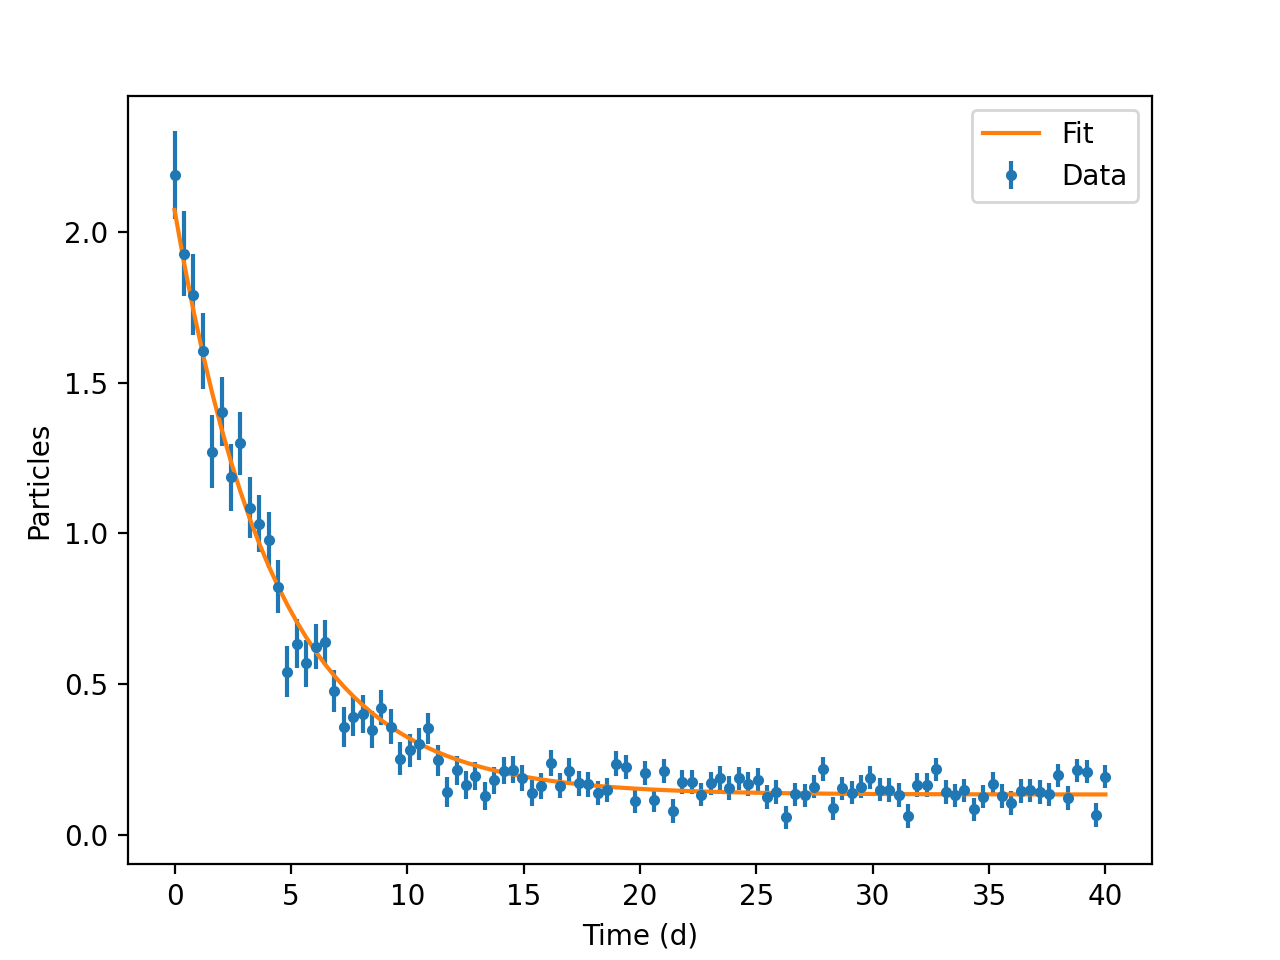

In [10]:
decay_fig = plt.figure()
decay_axs = decay_fig.add_axes([0.1,0.1,0.8,0.8])
decay_axs.errorbar(decay_t, decay_N, yerr = decay_N_error, fmt='.', label = 'Data')
decay_axs.plot(decay_t, decay_fit(decay_t, *p_opt), label = 'Fit')
decay_axs.set_xlabel('Time (d)')
decay_axs.set_ylabel('Particles')
decay_axs.legend();

# Problem 2e

Plot the histogram distributions of the three fit parameters.

<IPython.core.display.Javascript object>


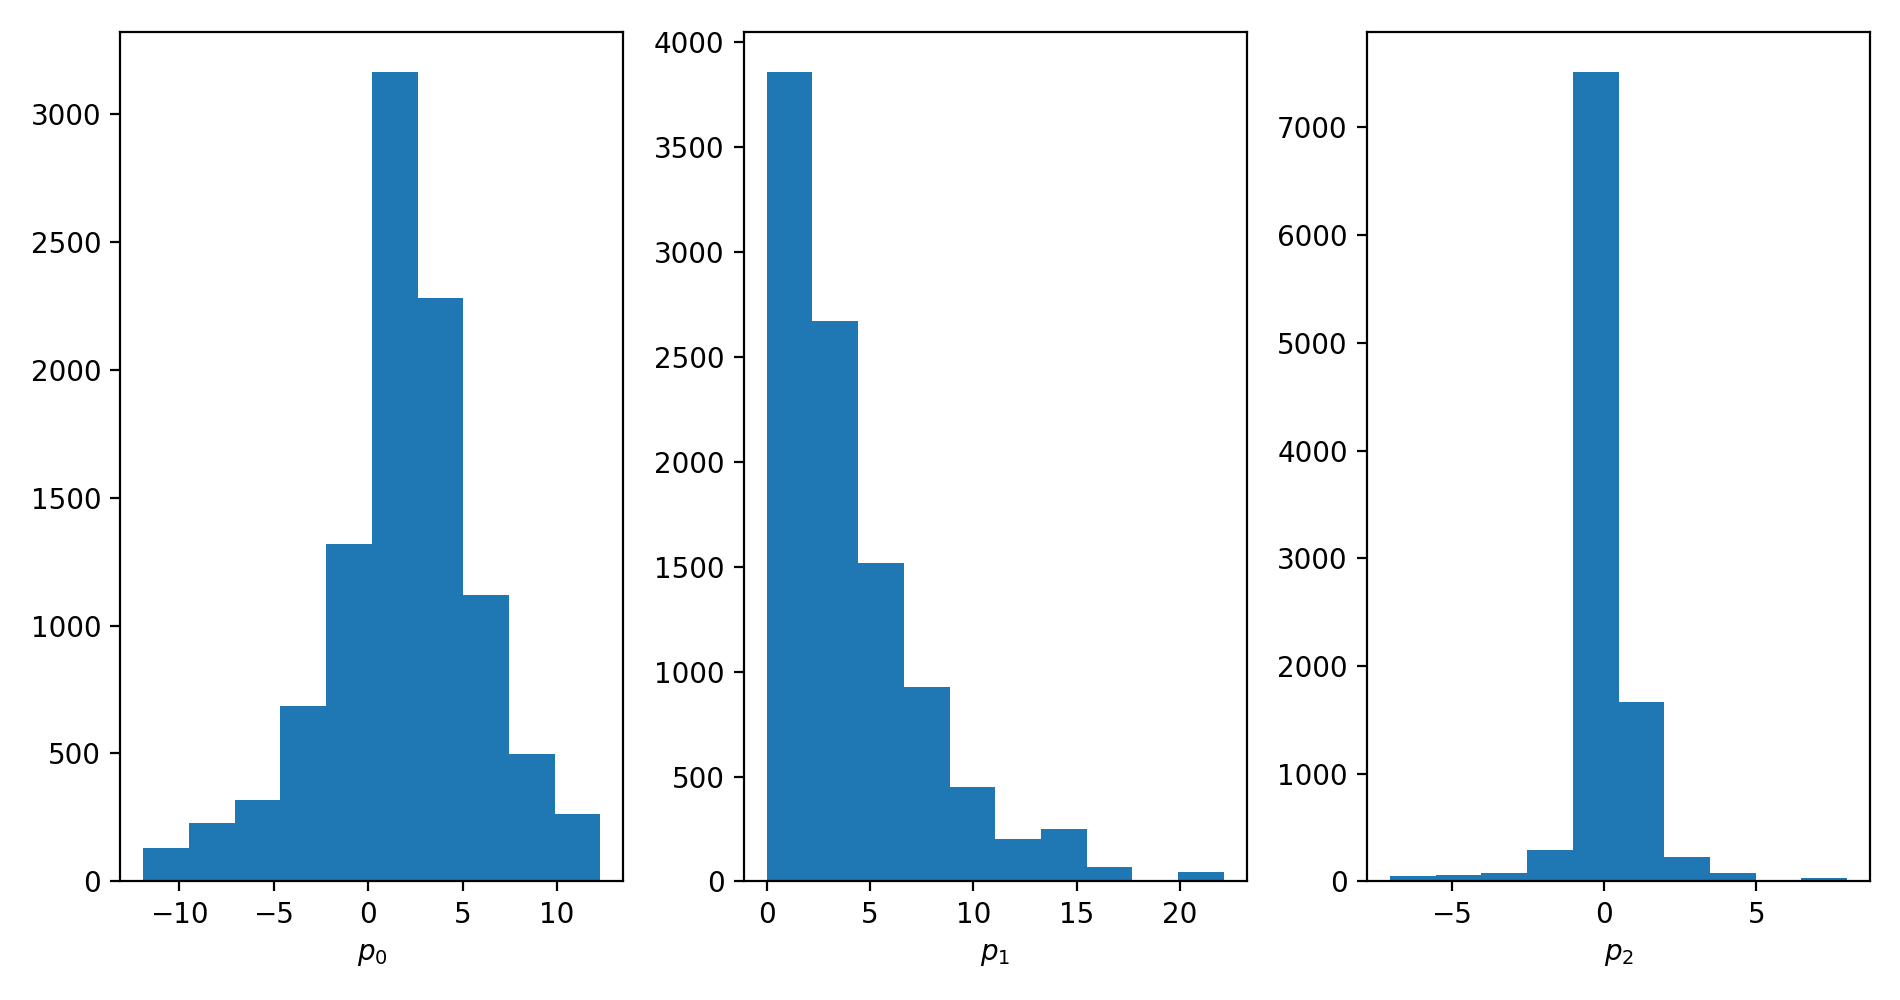

In [11]:
ps = np.array(params_list)
decay_params_fig, decay_params_axes = plt.subplots(1, 3)
decay_params_fig.set_figheight(5)
decay_params_fig.set_figwidth(9.5)
for i in range(0, len(ps[0])):
    decay_params_axes[i].hist(ps[:,i])
    decay_params_axes[i].set_xlabel(f'$p_{i}$')
plt.tight_layout();